In [1]:
from utils_project import *

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial n=579
Validation n=255
Combined n=834
Questionnaire items loaded


# Subjective mappings validate the behavioral mappings: locations are similar
- Doesnt necessarily have to precisely match but good to validate some basic assumptions
    - Behavior reflects relationship (e.g., the other person can see behavior, respond to it, etc)
    - Dots should reflect subjective model of the relationship
- Dots and task locations are correlated, using a variety of approaches (permutations, ols, rsa, cca)
    - smaller distances than shuffled characters distances
    - dimension tendency ~correlates with dots in OLS
    - pairwise distances correlate in RSA
    - Adjusting by the neutral characters dots locations improves the correlation



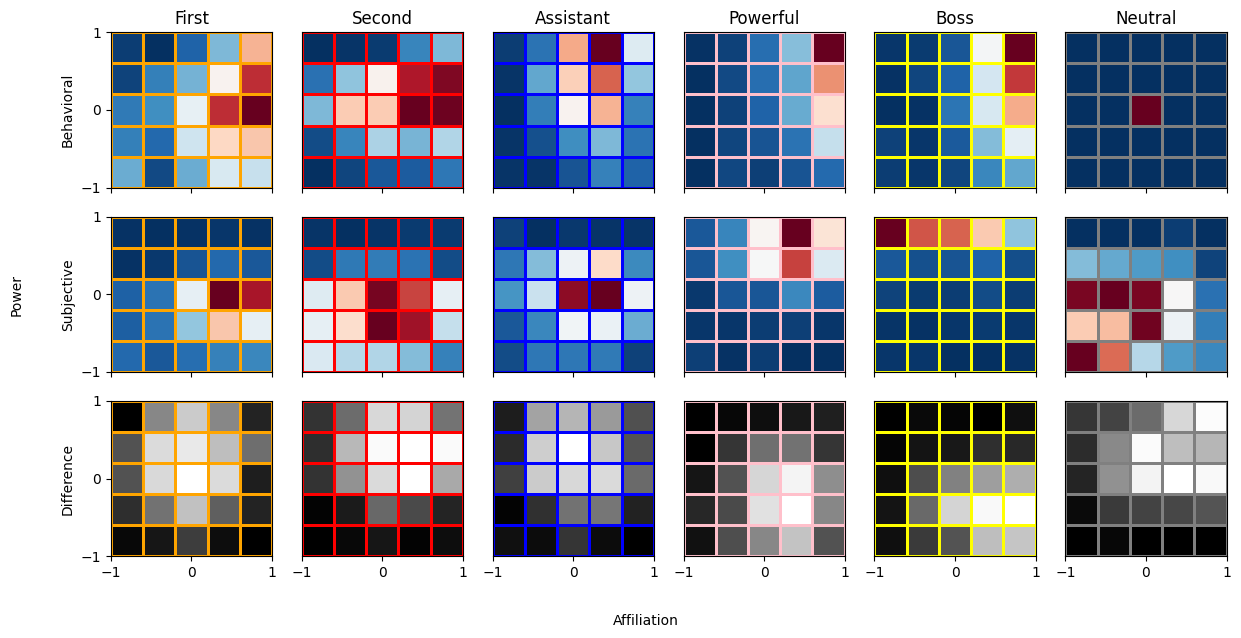

In [4]:
nrows = 3
fig, axs = plt.subplots(nrows, 6, figsize=(12, 2*nrows), sharex=True, sharey=True)
fig.subplots_adjust(top=0.95)
fig.text(0.5, -0.05, 'Affiliation', ha='center')
fig.text(-0.03, 0.5, 'Power',va='center', rotation='vertical')

norm_binedges = np.array([-1, -.6, -.2, .2, .6, 1]) 
bins = [norm_binedges, norm_binedges]
for c, role in enumerate(character_roles):
    
    axs[0,c].set_title(character_roles[c].capitalize())

    # behavior
    ax = axs[0,c]
    task_affil, task_power = data[f'affil_mean_{role}'], data[f'power_mean_{role}']
    ax.hist2d(task_affil, task_power, cmap='RdBu_r',
              bins=bins, color=character_colors[c])
    ax.set_ylabel('Behavioral')

    # subjective
    ax = axs[1,c]
    dots_affil, dots_power = data[f'{role}_dots_affil'], data[f'{role}_dots_power']
    ax.hist2d(dots_affil, dots_power, cmap='RdBu_r', 
              bins=bins, color=character_colors[c])
    ax.set_ylabel('Subjective')

    # difference
    ax = axs[2,c]
    ax.hist2d(task_affil-dots_affil, task_power-dots_power, cmap='Greys_r',
              bins=bins, color=character_colors[c])
    ax.set_ylabel('Difference')

    # # subjective (neutral adj.)
    # ax = axs[3,c]
    # dots_affil_adj, dots_power_adj = data[f'{role}_dots_affil_adj'], data[f'{role}_dots_power_adj']
    # ax.hist2d(dots_affil_adj, dots_power_adj, cmap='RdBu_r', 
    #           bins=bins, color=character_colors[c])
    # ax.set_ylabel('Subjective (neutral adj.)')

    # # difference (neutral adj.)
    # ax = axs[4,c]
    # ax.hist2d(task_affil-dots_affil_adj, task_power-dots_power_adj, cmap='Greys_r',
    #           bins=bins, color=character_colors[c])
    # ax.set_ylabel('Difference (neutral adj.)')

    for ax in axs[:, c]:
        ax.set_yticks([-1,0,1])
        ax.set_xticks([-1,0,1])

    if c > 0: [axs[r,c].axes.get_yaxis().set_visible(False) for r in np.arange(0, nrows)] 

plt.tight_layout()

# fig.savefig(fig_dir + "/behavior_dots.png", dpi=150)
# plt.show()

In [12]:
for s, sample in enumerate(samples[:2]):

    print(f'\n{sample}\n')

    df = sample_dict[sample]['data']

    # permutation test
    perm_diffs = (df['beh_dots_dist_mean'] - df['beh_dots_dist_shuff_mean']) / df['beh_dots_dist_shuff_std']
    df['beh_dots_dist_z'] = perm_diffs
    t, tp = ttest_1samp(perm_diffs, popmean=0, alternative='less')
    dof = len(perm_diffs) - 1

    # rsa
    taus = np.array(df['beh_dots_pw_dist_tau'].values)
    taus = taus[np.isfinite(taus)]
    w, wp = wilcoxon(taus, alternative='greater')

    # # ols
    # ols_res = []
    # for dv, bv in itertools.product(['dots_power_mean', 'dots_affil_mean'], 
    #                                 ['power_mean_mean', 'affil_mean_mean']):
    #     ols_df = run_ols(X=bv, y=dv, data=df, covariates=all_controls)[0]
    #     ols_df.insert(0, 'sample', sample)
    #     ols_res.append(ols_df[ols_df['x'].isin([bv])])

    # print results
    print(f' - permutation test: df({dof}) t={t:.2f}, p={tp:.4f}')
    print(f' - rsa: w={w:.2f}, p={wp:.5f}')
    # print_df(pd.concat(ols_res))


#------------------------------------------#
# RSA across dims etc...
#------------------------------------------#

#     # get character data
#     affil = df[[f'affil_mean_{role}' for role in roles]]
#     power = df[[f'power_mean_{role}' for role in roles]]
#     dots_affil = df[[f'{role}_dots_affil' for role in roles]]
#     dots_power = df[[f'{role}_dots_power' for role in roles]]

#     # get rdvs
#     affil_rdvs = [get_rdv(af.values.reshape(-1, 1)) for _, af in affil.iterrows()]
#     power_rdvs = [get_rdv(pw.values.reshape(-1, 1)) for _, pw in power.iterrows()]
#     dots_affil_rdvs = [get_rdv(daf.values.reshape(-1, 1)) for _, daf in dots_affil.iterrows()]
#     dots_power_rdvs = [get_rdv(dpw.values.reshape(-1, 1)) for _, dpw in dots_power.iterrows()]

#     # get kendall taus 
#     affil_taus  = np.array([kendalltau(affil_rdvs[i], dots_affil_rdvs[i])[0] for i in range(n)])
#     power_taus  = np.array([kendalltau(power_rdvs[i], dots_power_rdvs[i])[0] for i in range(n)])
#     dots_taus   = [kendalltau(dots_affil_rdvs[i], dots_power_rdvs[i])[0] for i in range(n)]
#     task_taus   = [kendalltau(affil_rdvs[i], power_rdvs[i])[0] for i in range(n)]
#     cross1_taus = [kendalltau(affil_rdvs[i], dots_power_rdvs[i])[0] for i in range(n)]
#     cross2_taus = [kendalltau(power_rdvs[i], dots_affil_rdvs[i])[0] for i in range(n)]

#     affil_p = wilcoxon(affil_taus[np.isfinite(affil_taus)], alternative='greater')[1]
#     power_p = wilcoxon(power_taus[np.isfinite(power_taus)], alternative='greater')[1]

#     print(f'{sample} n={np.sum(np.isfinite(affil_taus))}: affil p={affil_p:.3f}, power p={power_p:.3f}')


Initial

 - permutation test: df(578) t=-18.29, p=0.0000
 - rsa: w=108773.50, p=0.00000

Validation

 - permutation test: df(254) t=-10.63, p=0.0000
 - rsa: w=21622.50, p=0.00000


# Subjective ratings validate 2D structure in both behavior & dots (Validation sample only)

- Liking and impact difference are better than other possible social dimensions

In [5]:
get_cols('self')

,first_likability_self,second_likability_self,powerful_likability_self,boss_likability_self,assistant_likability_self,neutral_likability_self,self_competence,self_dominance,self_popularity,self_likability,self_friendliness,self_impact,self_quadrant,self_quadrant_relative,likability_selfOther_avg,impact_selfOther_diff,self_likability_rescaled,self_impact_rescaled
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,79.0,64.0,87.0,39.0,96.0,68.0,58.0,23.0,19.0,34.0,72.0,68.0,2.0,2.0,39.7500,-24.6667,-0.32,0.36
830,90.0,61.0,100.0,90.0,62.0,75.0,68.0,62.0,83.0,72.0,100.0,60.0,1.0,2.0,70.4167,-0.8333,0.44,0.20
831,91.0,96.0,75.0,60.0,65.0,42.0,80.0,33.0,59.0,63.0,65.0,25.0,4.0,3.0,51.7500,25.0000,0.26,-0.50
832,100.0,100.0,80.0,50.0,68.0,79.0,100.0,50.0,50.0,87.0,100.0,72.0,1.0,1.0,72.5000,-29.5000,0.74,0.44


In [12]:
df = sample_dict['Validation']['data']
beh_vars = ['affil_mean_mean', 'power_mean_mean']
# sr_vars = ['likability_mean', 'self_likability', 'likability_diff_mean',
#            'impact_mean', 'self_impact', 'impact_diff_mean',
#            'friendliness_mean', 'self_friendliness', 'friendliness_diff_mean',
#            'popularity_mean', 'self_popularity', 'popularity_diff_mean',
#            'competence_mean', 'self_competence', 'competence_diff_mean',
#            'dominance_mean', 'self_dominance', 'dominance_diff_mean']
sr_vars = ['likability_mean', 'friendliness_mean', 'popularity_mean',
           'impact_mean', 'competence_mean', 'dominance_mean',
           'impact_diff_mean', 'competence_diff_mean', 'dominance_diff_mean']

# zscore
for sv in sr_vars:
    if sv not in df.columns:
        print(f'{sv} not in df')
    df[f'{sv}_z'] = scipy.stats.zscore(df[sv])
    
# run ols
ols_res = []
for sv, bv in itertools.product(sr_vars, beh_vars):
    ols_df = run_ols(X=f'{sv}_z', y=bv, data=df, covariates=all_controls, verbose=False)[0]
    ols_res.append(ols_df[ols_df['x'].isin([f'{sv}_z'])])
ols_df = pd.concat(ols_res).iloc[:, 1:]
ols_df = ols_df.sort_values(by=['y', 'bic'])
print_df(ols_df)

|    | y               | x                      |   dof |   adj_rsq |    bic |    aic |        beta |        se |      95%_lb |    95%_ub |          t |         z |           p |   p_left |     p_right |
|---:|:----------------|:-----------------------|------:|----------:|-------:|-------:|------------:|----------:|------------:|----------:|-----------:|----------:|------------:|---------:|------------:|
|  1 | affil_mean_mean | likability_mean_z      |   232 |     0.194 | 773.07 | 691.62 |  0.404492   | 0.0584271 |  0.289376   | 0.519608  |  6.92302   | 6.59365   | 4.29131e-11 | 1        | 2.14566e-11 |
|  1 | affil_mean_mean | impact_mean_z          |   232 |     0.087 | 804.85 | 723.4  |  0.247277   | 0.0635702 |  0.122029   | 0.372526  |  3.88983   | 3.82445   | 0.000131062 | 0.999934 | 6.5531e-05  |
|  1 | affil_mean_mean | dominance_mean_z       |   232 |     0.055 | 813.67 | 732.22 |  0.165899   | 0.0639743 |  0.0398544  | 0.291944  |  2.59322   | 2.57195   | 0.0101128   | 0.994

### Competence and dominance relate to the impact ratings

In [10]:
xvars = ['competence_diff_mean', 'dominance_diff_mean']
# xvars = ['competence_mean', 'dominance_mean']
ols_df = run_ols(X=xvars, y='power_mean_mean', data=df, covariates=all_controls, verbose=False)[0]
display(ols_df[ols_df['x'].isin(xvars)])
ols_df = run_ols(X=xvars, y='impact_diff_mean', data=df, covariates=all_controls, verbose=False)[0]
display(ols_df[ols_df['x'].isin(xvars)])

,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,z,p,p_left,p_right
1,Intercept + competence_diff_mean + dominance_d...,power_mean_mean,competence_diff_mean,231.0,0.098,806.08,721.09,0.1085,0.0642,-0.018,0.2351,1.6897,1.6827,0.0924,0.9538,0.0462
2,Intercept + competence_diff_mean + dominance_d...,power_mean_mean,dominance_diff_mean,231.0,0.098,806.08,721.09,0.1476,0.0642,0.021,0.2742,2.2976,2.2822,0.0225,0.9888,0.0112


,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,z,p,p_left,p_right
1,Intercept + competence_diff_mean + dominance_d...,impact_diff_mean,competence_diff_mean,231.0,0.328,731.03,646.04,0.3812,0.0554,0.2719,0.4904,6.8750,6.5507,5.7281e-11,1.0,2.8640e-11
2,Intercept + competence_diff_mean + dominance_d...,impact_diff_mean,dominance_diff_mean,231.0,0.328,731.03,646.04,0.2825,0.0555,0.1732,0.3918,5.0943,4.9540,7.2713e-07,1.0,3.6356e-07


In [ ]:
#--------------------------------------------------------------
# CCA analysis
#--------------------------------------------------------------

# task    = data[['affil_mean_mean', 'power_mean_mean']]
# dots    = data[['dots_affil_mean', 'dots_power_mean']]
# ratings = data[['impact_diff_mean', 'likability_mean']] 
# for cc in [[task, dots], [ratings, task], [ratings, dots]]:
#     mask = np.sum(np.isfinite(cc[0]), 1) == cc[0].shape[1]
#     cc[0] = scipy.stats.zscore(cc[0][mask])
#     cc[1] = scipy.stats.zscore(cc[1][mask])
#     cca = CanCorr(cc[0], cc[1]) # order doesnt matter
#     print(f'CCA between {list(cc[0].columns)} {list(cc[1].columns)}')
#     print(cca.corr_test().summary())

# Plot validation results

Initial: p=0.00
Validation: p=0.00


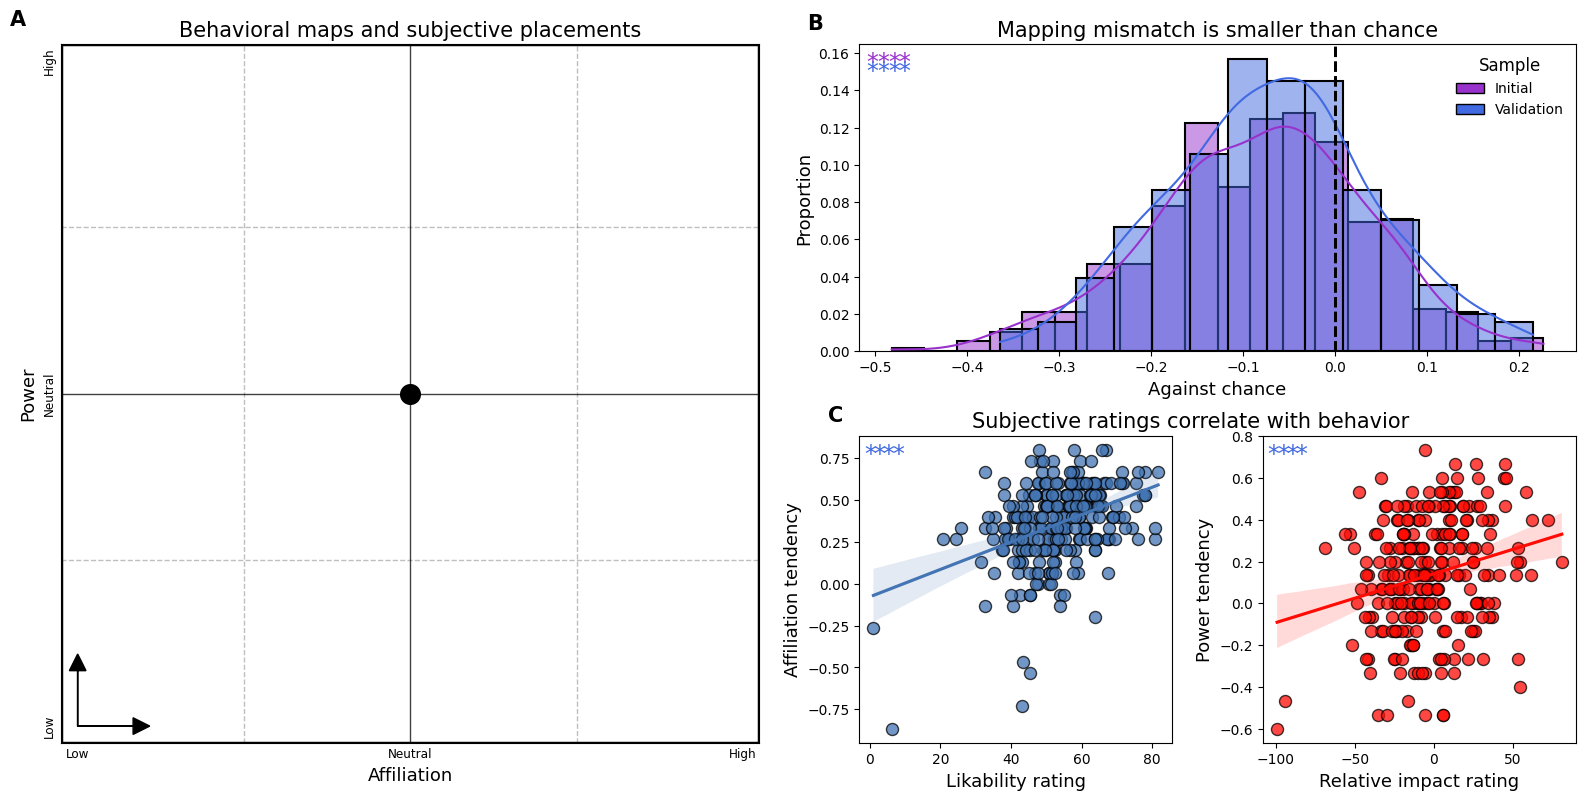

In [8]:
fig, axs = create_subplots((2,4), {(0,0): (2,2), (0,2): (1, 2)}, figsize=(16, 8), annotate=False)
# fig.suptitle('Behavioral geometry is consistent with subjective social mapping', fontsize=suptitle_fontsize, y=1.02)

#------------------------------------------------------------
# # soical space mapping
#------------------------------------------------------------


ax = axs[0]
add_subfig_letter(ax, 'A', y=1.05, fontsize=title_fontsize)
ax.set_title('Behavioral maps and subjective placements', fontsize=title_fontsize)
plot_social_space(ax, label_fontsize=label_fontsize)
# colors = ['r', 'b', 'g']
# XYs = np.array([[[.4, .5], [.2, .8]], 
#                 [[-.1, -.5], [-.7, -.8]],
#                 [[.23, -.67], [.7, -.72]]])
# for xy, color in zip(XYs, colors):
#     ax.scatter(*xy.T, s=100, c=color, zorder=1)


#------------------------------------------------------------
# permutation distance analysis
#------------------------------------------------------------

ax = axs[1]
add_subfig_letter(ax, 'B', fontsize=title_fontsize)
ax.set_title('Mapping mismatch is smaller than chance', fontsize=title_fontsize)
ax.set_ylabel('Proportion', fontsize=label_fontsize)
ax.set_xlabel('Against chance', fontsize=label_fontsize)
for s, sample in enumerate(samples[:2]):
    df = sample_dict[sample]['data']
    color = sample_colors[s]
    perm_diffs = df['beh_dots_dist_mean'] - df['beh_dots_dist_shuff_mean']
    ax = plot_histplot(perm_diffs, ax=ax, color=color, stat='probability')
    tp = ttest_1samp(perm_diffs, popmean=0, alternative='less')[1]
    print(f'{sample}: p={tp:.2f}')
    plot_significance(ax, tp, sig_level=4, color=color, x=0.01, y=0.98-s*0.03, fontsize=17)
    ax.axvline(0, color='black', linestyle='--', linewidth=2)

# add a legend for samples
handles = [mpatches.Patch(facecolor=sample_colors[s], edgecolor='black', hatch='', label=sample) for s, sample in enumerate(samples[:2])]
ax.legend(handles=handles, title='Sample', title_fontsize=legend_title_fontsize,
          loc='upper right', fontsize=legend_label_fontsize, frameon=False)


#------------------------------------------------------------
# plot rating correlations
#------------------------------------------------------------


df = sample_dict['Validation']['data']
plot_vars = [['likability', 'affil'], ['likability', 'power'], ['impact_diff', 'affil'], ['impact_diff', 'power']]

plt.figtext(.75, 0.48, 'Subjective ratings correlate with behavior', ha='center', va='center', fontsize=title_fontsize)

# likability & affil, impact_diff & power
ax = axs[2]
add_subfig_letter(ax, 'C', fontsize=title_fontsize)
ax = plot_regplot(df['likability_mean'], df['affil_mean_mean'], ax=ax, color="#4374B3")
res_df = run_ols(X='likability_mean', y='affil_mean_mean', data=df, covariates=all_controls)[0]
p = res_df[res_df['x']=='likability_mean']['p_right'].values[0]
plot_significance(ax, p, sig_level=4, color=sample_colors[1], x=0.015, y=0.98, dx=0.03, fontsize=17)
ax.set_xlabel('Likability rating', fontsize=label_fontsize)
ax.set_ylabel('Affiliation tendency', fontsize=label_fontsize)

ax = axs[3]
ax = plot_regplot(df['impact_diff_mean'], df['power_mean_mean'], ax=ax, color="#FF0B04")
res_df = run_ols(X='impact_diff_mean', y='power_mean_mean', data=df, covariates=all_controls)[0]
p = res_df[res_df['x']=='impact_diff_mean']['p_right'].values[0]
plot_significance(ax, p, sig_level=4, color=sample_colors[1], x=0.015, y=0.98, dx=0.03, fontsize=17)
ax.set_xlabel('Relative impact rating', fontsize=label_fontsize)
ax.set_ylabel('Power tendency', fontsize=label_fontsize)

# add snignificance for both
# for i, (rating, beh) in enumerate([['likability_mean', 'affil_mean_mean'], ['impact_diff_mean', 'power_mean_mean']]):
#     ols_df = run_ols(rating, beh, df)[0]
#     p = ols_df[ols_df['x'].isin([rating])]['p'].values[0]
#     plot_significance(axs[2+i], p, sig_level=4, x=0.85, y=0.06, dx=0.03, fontsize=17)
# fig.text(-0.01, 0.5, 'Character ratings', va='center', rotation='vertical', fontdict={'fontsize': 15})
# fig.text(0.5, -0.01, 'Interaction decisions', ha='center', fontdict={'fontsize': 15})

plt.subplots_adjust(hspace=0.7) # Adjust vertical_spacing = 0.5 * axes_height
plt.tight_layout()
save_figure(fig, f'{fig_dir}/Fig1_Behavioral-validation')